In [ ]:
import sys

import torch

sys.path.append("..")


In [ ]:
from data.dataloader import LowLightDataModule
from model.blocks.homomorphic import ImageComposition, ImageDecomposition
from utils.utils import show_batch, summarize_model


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=512,
    batch_size=1,
    num_workers=4,
)

data_module.setup(stage="fit")


In [ ]:
train_dataloader = data_module.train_dataloader()


torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


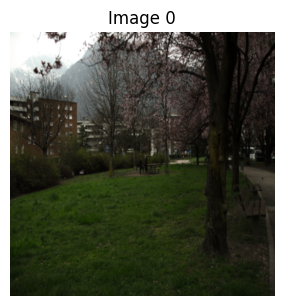

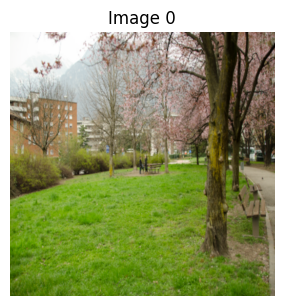

In [ ]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
show_batch(images=train_low)
show_batch(images=train_high)


In [ ]:
decompose = ImageDecomposition(offset=0.5, cutoff=0.1)
compose = ImageComposition(offset=0.5)


In [ ]:
train_low = train_low.cuda()
decompose = decompose.cuda()
compose = compose.cuda()


In [ ]:
luminance, chroma_red, chroma_blue, illuminance, reflectance = decompose(train_low)
rgb, lu = compose(chroma_red, chroma_blue, illuminance, reflectance)


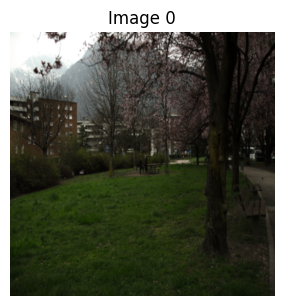

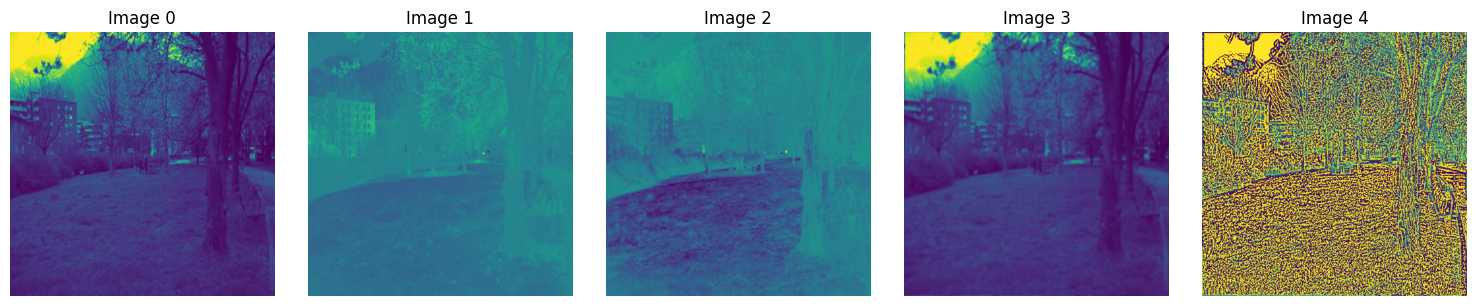

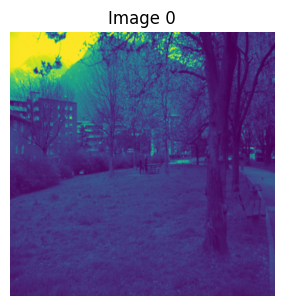

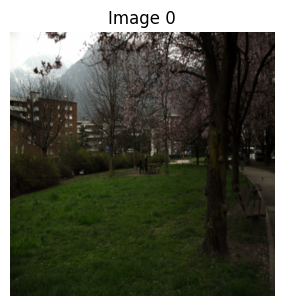

In [ ]:
show_batch(images=train_low)
show_batch(
    images=torch.cat(
        tensors=[luminance, chroma_red, chroma_blue, illuminance, reflectance], dim=0
    )
)
show_batch(images=lu)
show_batch(images=rgb)


In [ ]:
summarize_model(model=decompose, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
ImageDecomposition                       [1, 1, 256, 256]          --
├─RGB2YCrCbBlock: 1-1                    [1, 1, 256, 256]          --
├─HomomorphicSeparationBlock: 1-2        [1, 1, 256, 256]          --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.79
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.79

In [ ]:
input_tensors = [
    torch.randn(1, 1, 256, 256, device="cuda"),  # cr
    torch.randn(1, 1, 256, 256, device="cuda"),  # cb
    torch.randn(1, 1, 256, 256, device="cuda"),  # il
    torch.randn(1, 1, 256, 256, device="cuda"),  # re
]
summarize_model(model=compose, input_data=input_tensors)


Layer (type:depth-idx)                   Output Shape              Param #
ImageComposition                         [1, 3, 256, 256]          --
├─YCrCb2RGBBlock: 1-1                    [1, 3, 256, 256]          --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.05